### STROKE PREDICTIONS

This analysis is based on this data availanle on kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

We have the following avaialble features:

id: unique identifier
gender: "Male", "Female" or "Other"
age: age of the patient
hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
ever_married: "No" or "Yes"
work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
Residence_type: "Rural" or "Urban"
avg_glucose_level: average glucose level in blood
bmi: body mass index
smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
stroke: 1 if the patient had a stroke or 0 if not

MAIN GOAL:
Make acceptable performance stroke cases classification model with the available information. Recall > Baseline model

Information available is a mix of basic medical and social attributes of the patient, proper stroke classification model could benefit from more medical information.

Tasks:
Feature explorative analysis, insights and intuition building abour stroke cases
Feature selection using statistical significance test. This will be used to detect features that are statistically significant to strokes. (chi-square test)
Baseline model will be established with the goal to outperform the results of it, this will be based on the recall.
Model selection: several models will be tried in order to see what are few the potentialy good models.
Model will be compared by recall and f1 scores as data is highly inbalanced: we have relatevly few cases of stroke in the data set. Maximizing recall we aim to be have as many as possible true stroke cases predicted at the cost of having more false positives then usually is accepted because it is better to evaluate the risk of potential stroke case then don't even recognize the possibe risk and send the patient home as healthy.
Model evaluation based on recall, f1 scores, ROC AUC.
Feature importance analysis, we will look at what patient attributes have most predictive power are most important when distinguishing stroke and no strokes patient cases.


In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score, precision_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import pickle
import warnings
warnings.filterwarnings('ignore')

In [67]:
from data_report_tools import cleaning_data

In [68]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [69]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [71]:
columns_to_convert = ['hypertension', 'heart_disease', 'stroke']

for column in columns_to_convert:
    df[column] = df[column].astype(bool)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   bool   
 4   heart_disease      5110 non-null   bool   
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 374.4+ KB


In [73]:
cleaning_data(df)

Missing Values per Column:
bmi    201
dtype: int64

Number of Duplicated Rows: 0


In this data set we have 201 missing values in body mass index feature.

These values will be imputed with medial value of the bmi

In [74]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


Insights:
* there doesn't seem to be any extreme values
* there are age values that might be incorrect 0.08.
Actions:
* check if this is baby age expressed in years, maybe there are more cases like this, also value even though looks extreme from the IQR we can see that this value wouldn't be shown as outlier.

In [75]:
df.sort_values(by = 'age', ascending = True).head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3295,29955,Male,0.08,False,False,No,children,Rural,70.33,16.9,Unknown,False
1614,47350,Female,0.08,False,False,No,children,Urban,139.67,14.1,Unknown,False
3618,22877,Male,0.16,False,False,No,children,Urban,114.71,17.4,Unknown,False
4021,8247,Male,0.16,False,False,No,children,Urban,109.52,13.9,Unknown,False
3968,41500,Male,0.16,False,False,No,children,Rural,69.79,13.0,Unknown,False
3392,11371,Male,0.24,False,False,No,children,Urban,89.28,14.2,Unknown,False
996,53279,Male,0.24,False,False,No,children,Rural,118.87,16.3,Unknown,False
2898,64974,Male,0.24,False,False,No,children,Urban,58.35,18.6,Unknown,False
4293,69222,Male,0.24,False,False,No,children,Urban,57.09,19.4,Unknown,False
1999,42500,Male,0.24,False,False,No,children,Rural,146.97,18.5,Unknown,False


We can see more case of babies in the data set. This information then is not false. We just have a wide age range patients.

### Visual EDA

In [76]:
def generate_explorative_plots(df, target):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object', 'bool']).columns.tolist()

    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, y=column, x=target)
        plt.title(f'Box Plot of {column} by {target}')
        plt.show()

    for column in categorical_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=column, hue=target)
        plt.title(f'Bar Chart of {column} by {target}')
        plt.xticks(rotation=45)
        plt.show()

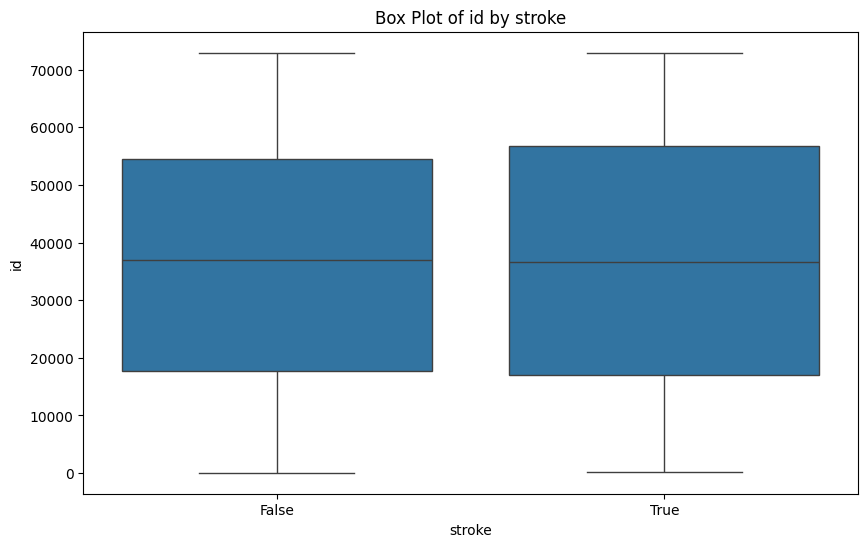

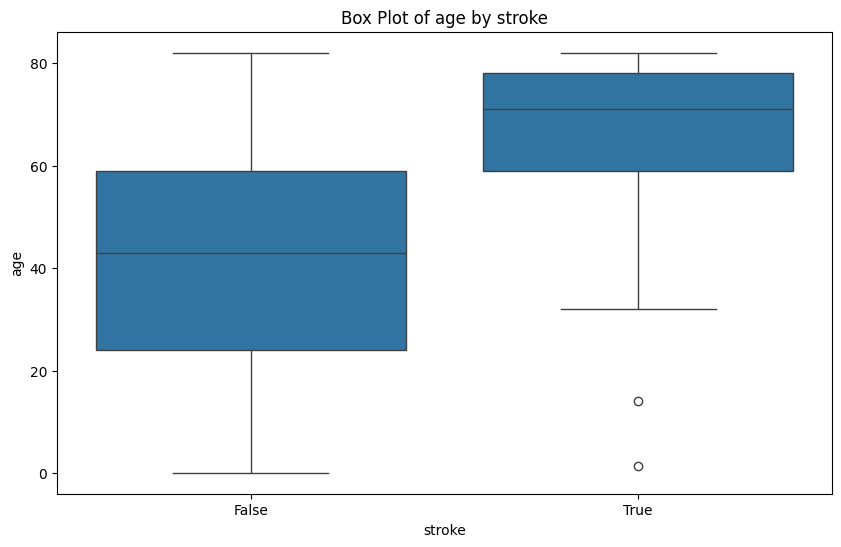

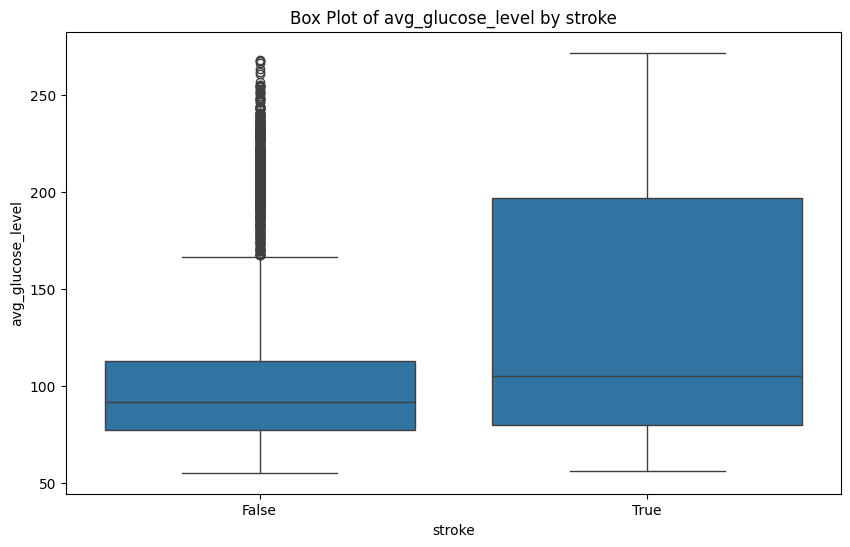

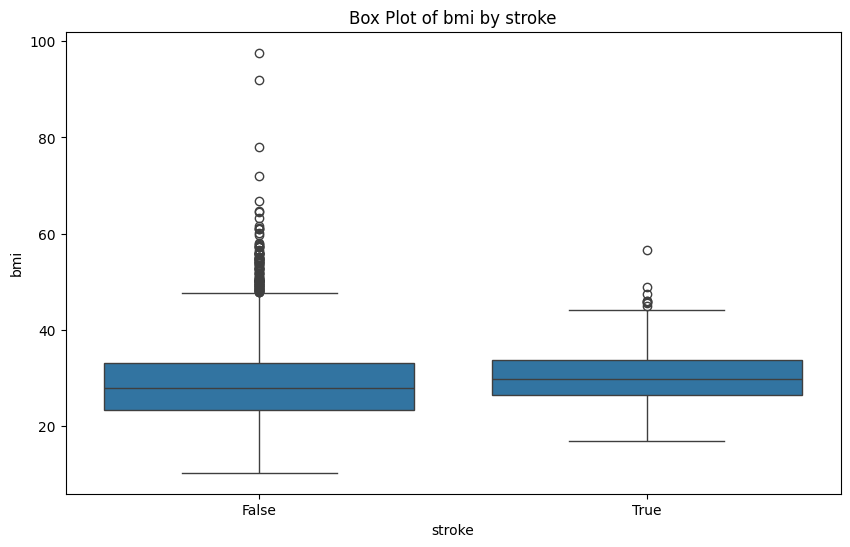

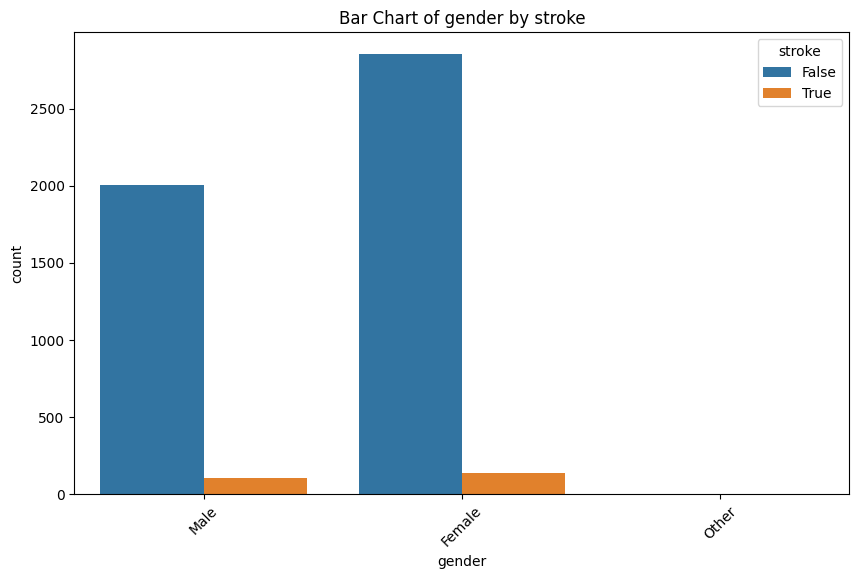

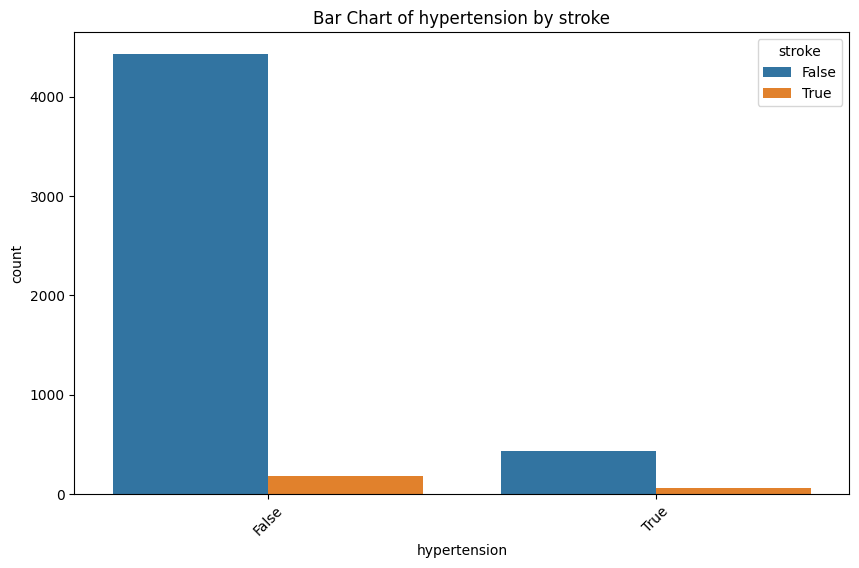

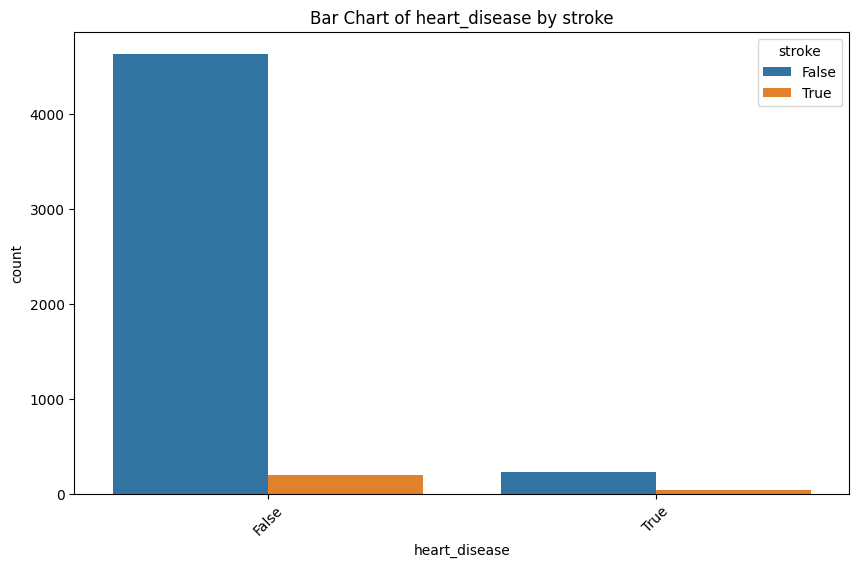

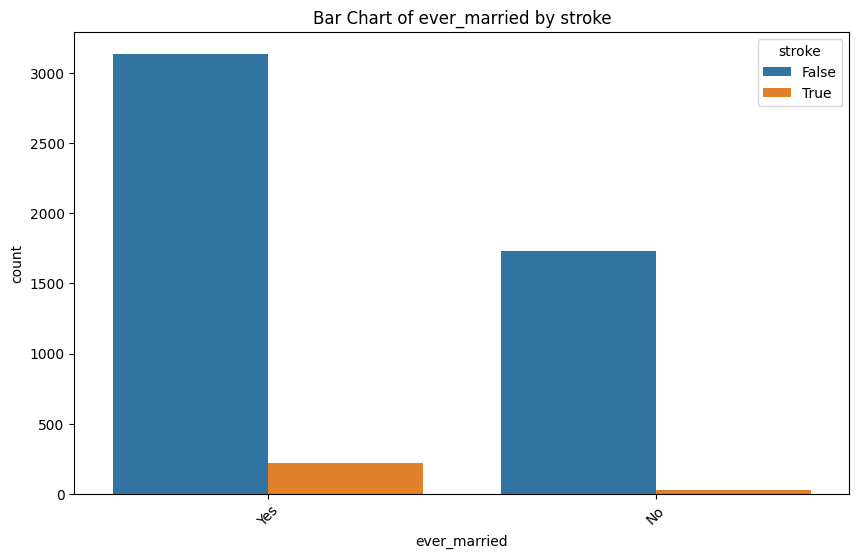

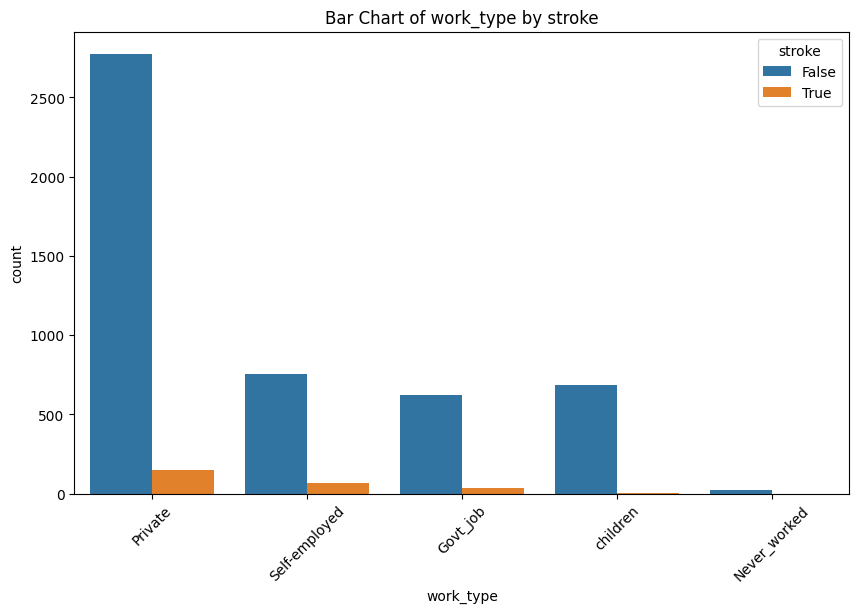

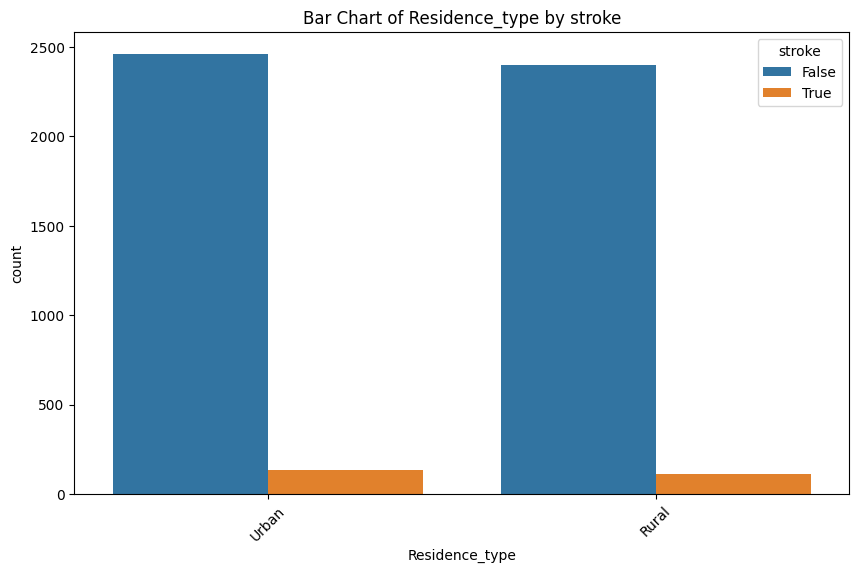

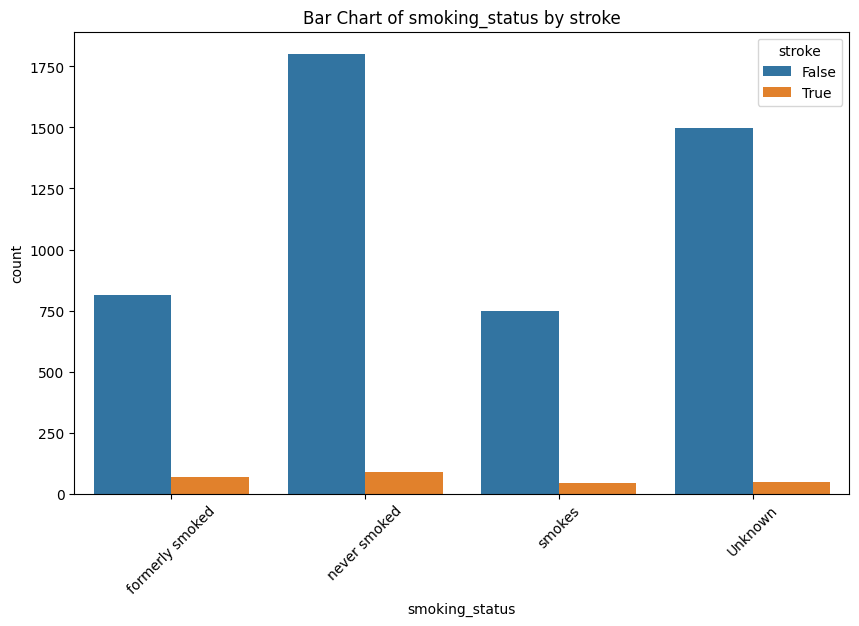

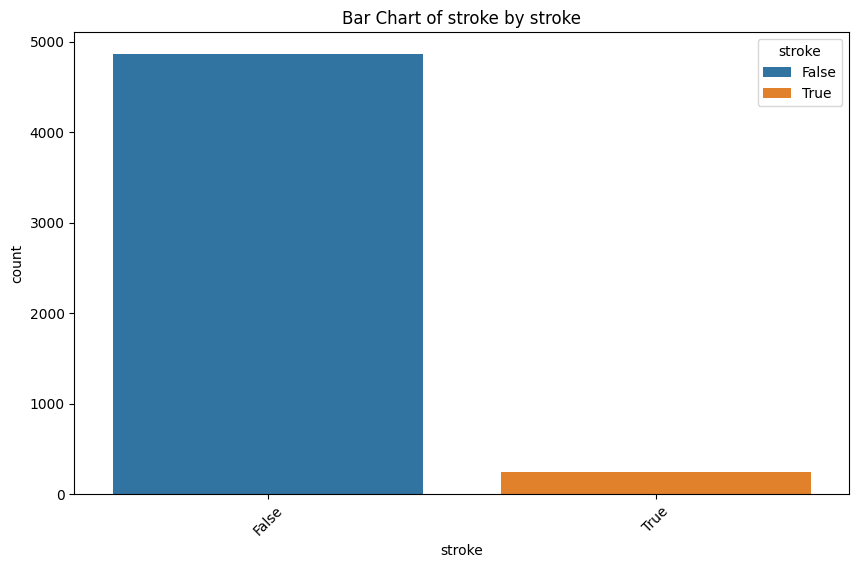

In [77]:
generate_explorative_plots(df, 'stroke')

We have one value for gender which says other, it could be potentialy an individual who is not identifying themself neither as Male or Female, however since we don't have any more cases like that we will treat it as an missing item and it will deleted from the data set and chi-squere test to potential proportional difference between Male and Female in stroke cases

In [78]:
df_filtered = df[df['gender'] != 'Other']

### statiscally significant difference testing in strokes cases in different groups


H0: There is no different between different groups(gender, hypertension cases, work type, residence type and other)
H1: There is a difference

significance level alpha=0.05

In [79]:
categorical_features = ['gender', 'hypertension', 'Residence_type', 'work_type',
                        'smoking_status', 'heart_disease', 'ever_married']


chi_square_results = []

for feature in categorical_features:
    contingency_table = pd.crosstab(df_filtered[feature], df_filtered['stroke'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append([feature, chi2, p])

chi_square_df = pd.DataFrame(chi_square_results, columns=['Features', 'Chi-Square', 'P-value'])

chi_square_df

,Features,Chi-Square,P-value
0,gender,0.340003,5.598278e-01
1,hypertension,81.573145,1.688936e-19
2,Residence_type,1.074971,2.998252e-01
3,work_type,49.159149,5.409035e-10
4,smoking_status,29.225727,2.007704e-06
5,heart_disease,90.229437,2.120831e-21
6,ever_married,58.867809,1.686286e-14


with the gender and residence type higher than 0.05 we are not able to reject H0, meaning in this sample there is not evidence that there is difference in gender groups or residence type proportions of stroke cases in this data. Possibly in the modeling part we will consider removing these feature and see is it changes the result.

### Baseline model

stratified baseline model as we have inbalanced target variable

In [80]:
X = df_filtered.drop('stroke', axis=1)
y = df_filtered['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#strategy='stratified
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

baseline_recall = recall_score(y_test, y_pred, pos_label=1)
baseline_f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Baseline Model Recall: {baseline_recall}")
print(f"Baseline Model F1 Score: {baseline_f1}")

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Baseline Model Recall: 0.04
Baseline Model F1 Score: 0.043478260869565216
Confusion Matrix:
[[932  40]
 [ 48   2]]

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.96      0.95       972
        True       0.05      0.04      0.04        50

    accuracy                           0.91      1022
   macro avg       0.50      0.50      0.50      1022
weighted avg       0.91      0.91      0.91      1022



Now we have to improve our recall results 0.04 recall and 0.04 f1 score

### Models exploration / Categorical feature's encoding

Given that categorical features like gender, work type, smoking history don't have a lot of different categories, first exploration of these feature encoding will start from one-hot encoding, however different approaches could be usefull as well.
For now I will try to do also ordinal coding for smoking, however the "unkown" value will probably have to treated as missing information. I will try creating separate column of smoking and in the ordinal smoking status it will coded as -1


In [81]:
categorical_features = ['gender', 'work_type', 'Residence_type', 'ever_married']
df_one_hot = pd.get_dummies(df_filtered[categorical_features])

df_filtered = pd.concat([df_filtered, df_one_hot], axis=1).drop(columns=categorical_features)

In [82]:
smoking_status_mapping = {
    'Unknown': -1,
    'never smoked': 1,
    'formerly smoked': 2,
    'smokes': 3
}

df_filtered['smoking_status_ordinal'] = df_filtered['smoking_status'].map(smoking_status_mapping)

df_filtered['smoking_status_unknown'] = df_filtered['smoking_status'].apply(lambda x: 1 if x == 'Unknown' else 0)

df_filtered = df_filtered.drop(columns=['smoking_status'])

In [83]:
imputer = SimpleImputer(strategy='median')
df_filtered['bmi'] = imputer.fit_transform(df_filtered[['bmi']])

In [84]:
df_filtered = df_filtered.drop(columns=['id'])

### Feature selection / Correlation analysis

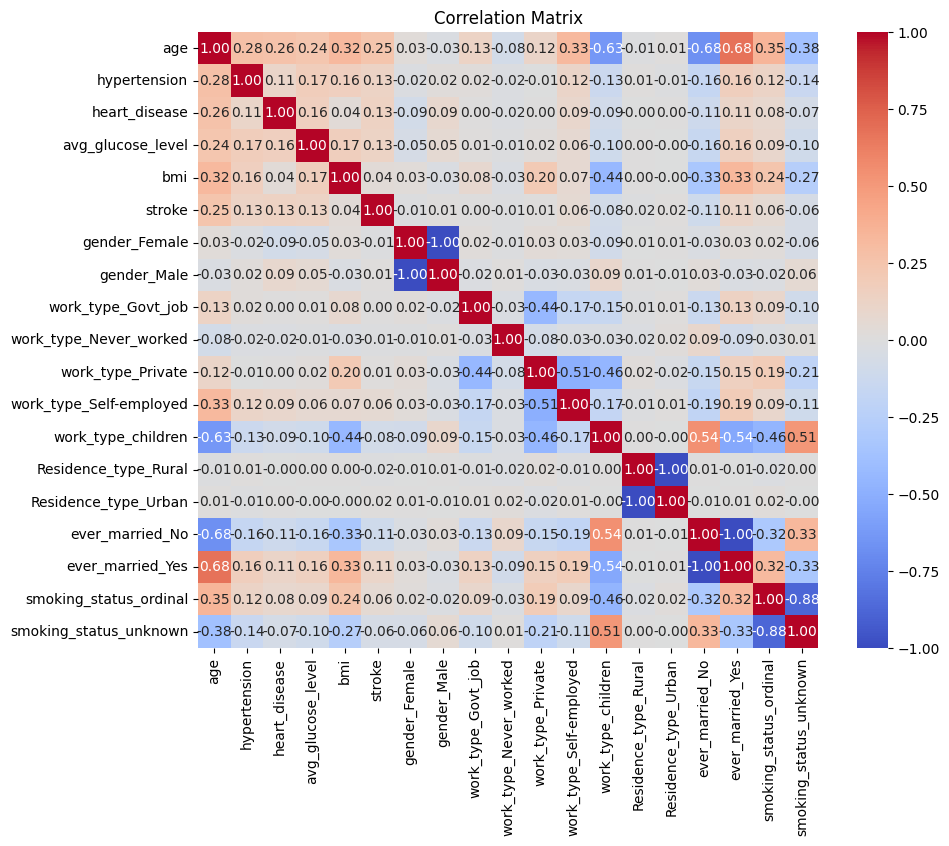

In [85]:
correlation_matrix = df_filtered.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

    -There is a strong negative correlation between age and work type children which is expected.

    -Looking at the stroke feature, variables with the strongest correlations with stroke occurrence are age, hypertension, heart_disease, glucose level, and bmi. This aligns well with medical intuition that these factors are associated with increased risk of stroke cases. The correlations are not very high but are enough to consider them as potentially important for predicting strokes.

    -There is a negative correlation between age and smoking status unknown (-0.38) suggesting that the chance of having an unknown smoking status decreases when aging. This indicates that older people have more definitive information about their smoking status in this data.

    -Vriables like residence type, gender and work type show very low correlations with stroke indicating that they might not be strong predictors for stroke cases.

Correlation results suggests the same as chi-square results, we can possibly remove gender and residence type from the data.

### Unkown smoking status distribution explorations

In [86]:
children_unknown_smokers_count = df[(df['work_type'] == 'children') & (df['smoking_status'] == 'Unknown')].shape[0]

children_unknown_smokers_count

618

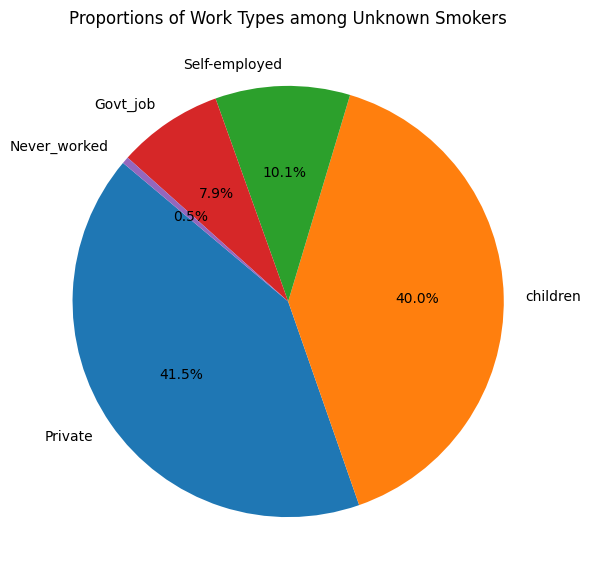

In [87]:
unknown_smokers = df[df['smoking_status'] == 'Unknown']

work_type_counts = unknown_smokers['work_type'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(work_type_counts, labels=work_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportions of Work Types among Unknown Smokers')
plt.show()

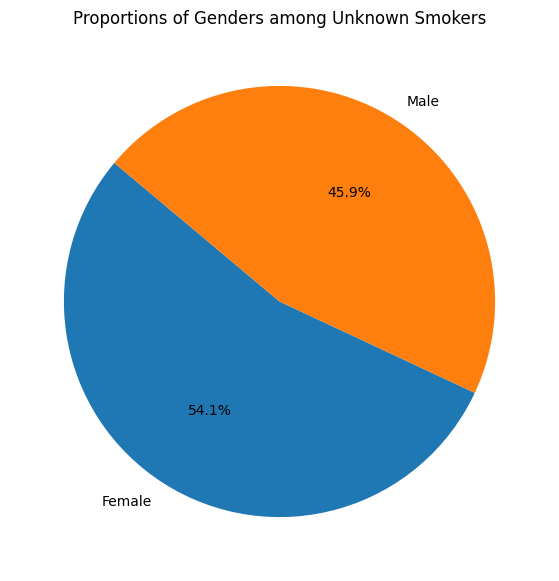

In [88]:
gender_counts = unknown_smokers['gender'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportions of Genders among Unknown Smokers')
plt.show()

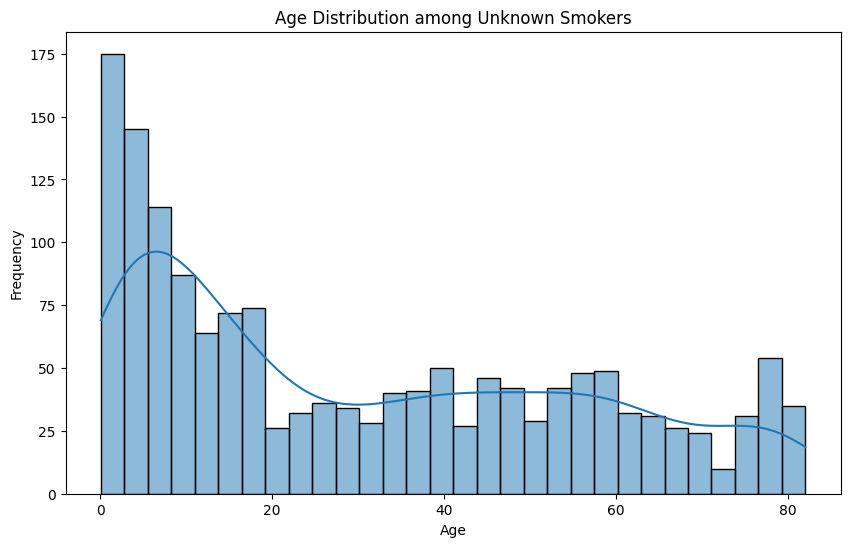

In [89]:
plt.figure(figsize=(10, 6))
sns.histplot(unknown_smokers['age'], kde=True, bins=30)
plt.title('Age Distribution among Unknown Smokers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

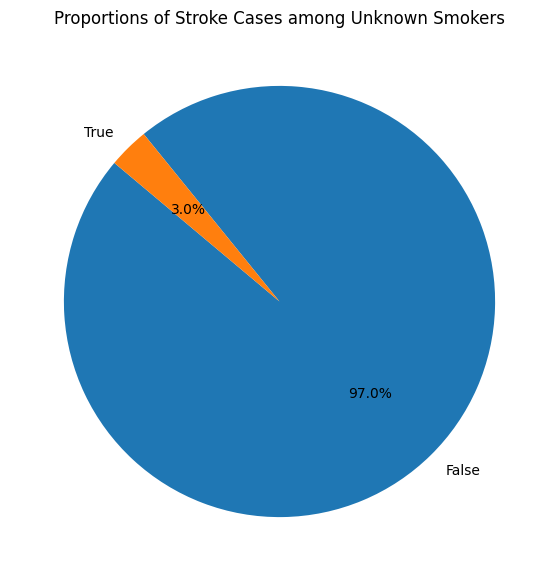

In [90]:
stroke_counts = unknown_smokers['stroke'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(stroke_counts, labels=stroke_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportions of Stroke Cases among Unknown Smokers')
plt.show()

Smoking status when coded ordinal way dosn't show strong correlation with stroke feature, however intuition says this could be potentially meaningfull feature to include in the model as independent variable. Plan is to keep it coded ordinally .

Intuition suggested that unkown smoking cases could've been for children however almost equal proportion of unkown cases appear to be for private work type individuals. Among other groups there wasn't high disproportoniality that it would indicate this is only due to one groups input.

### Transformation

Standartizing numerical features

In [91]:
preprocessor = Pipeline([
    ('scaler', StandardScaler(),)
])

In [92]:
X = df_filtered.drop('stroke', axis=1)
y = df_filtered['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_preprocessed = preprocessor.fit_transform(X_train)

### SMOTE to fix undersampled stroke cases

reikia aprašyti

Distribution before SMOTE: Counter({False: 3888, True: 199})
Class distribution after SMOTE: Counter({False: 3888, True: 3888})


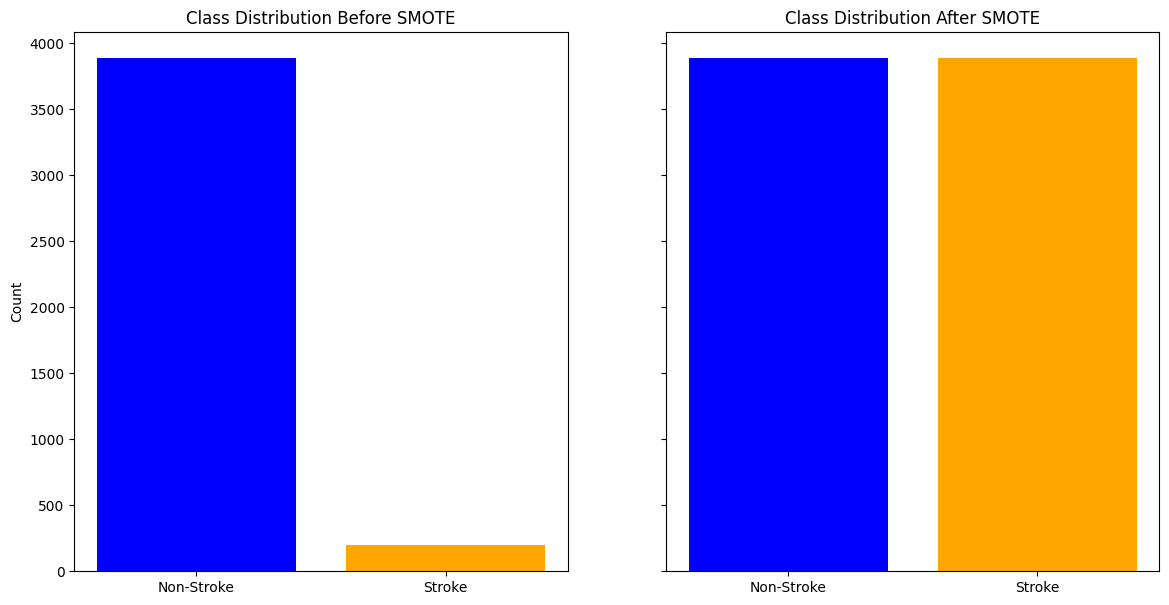

In [93]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

print("Distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_smote))

fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

axs[0].bar(['Non-Stroke', 'Stroke'], [Counter(y_train)[0], Counter(y_train)[1]], color=['blue', 'orange'])
axs[0].set_title('Class Distribution Before SMOTE')
axs[0].set_ylabel('Count')

axs[1].bar(['Non-Stroke', 'Stroke'], [Counter(y_train_smote)[0], Counter(y_train_smote)[1]], color=['blue', 'orange'])
axs[1].set_title('Class Distribution After SMOTE')

plt.show()

In [94]:
X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train.columns)

### Prediction

In [95]:
models = [
    LogisticRegression(random_state=42),
    SVC(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    GaussianNB(),
    KNeighborsClassifier()
]

In [96]:
for model in models:
    model.fit(X_train_smote_df, y_train_smote)

    X_test_preprocessed = preprocessor.transform(X_test)

    y_pred = model.predict(X_test_preprocessed)

    print(model.__class__.__name__)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

LogisticRegression
Accuracy: 0.7436399217221135
              precision    recall  f1-score   support

       False       0.99      0.74      0.85       972
        True       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.82      1022

SVC
Accuracy: 0.7808219178082192
              precision    recall  f1-score   support

       False       0.97      0.80      0.87       972
        True       0.11      0.48      0.18        50

    accuracy                           0.78      1022
   macro avg       0.54      0.64      0.53      1022
weighted avg       0.93      0.78      0.84      1022

DecisionTreeClassifier
Accuracy: 0.8874755381604696
              precision    recall  f1-score   support

       False       0.96      0.92      0.94       972
        True       0.11      0.18      0.14        50

    accuracy                           0.89      

It is better to have more false positives than false negatives, therefor we are looking at the recall.
I think the cost of missing a stroke case is high and we should prioritize recall metric to ensure as few stroke cases are missed as possible, even if it means we have false positives.

The Logistic Regression model has the highest recall for stroke cases (True class) at 80%, which means it's best at identifying true stroke cases among all models. However, its precision for stroke cases is quite low, leading to a lot of false positives but given the context, capturing as many true stroke cases as possible is crucial.

### Stroke classification

In [97]:
df = df[df['gender'] != 'Other']
df= df.drop(columns=['id', 'gender', 'Residence_type'])

Based on chi-square results and general undertanding of the data we are removing id, gender and residence type feature as meaningless to the classification excercise.

### Building Pipeline For Feature transformations

In [98]:
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


numeric_features = ['age', 'avg_glucose_level', 'bmi']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['work_type', 'ever_married']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

smoking_status_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[['never smoked', 'formerly smoked', 'smokes', 'Unknown']],
                               handle_unknown='use_encoded_value', unknown_value=-1))
])

boolean_features = ['hypertension', 'heart_disease']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('smoking_status', smoking_status_transformer, ['smoking_status']),
        ('bool', 'passthrough', boolean_features)
    ])

In [99]:
pipeline = make_pipeline_imblearn(
    preprocessor,
    SMOTE(random_state=42),
    LogisticRegression(random_state=42))

In [100]:
param_grid_lr = {
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l2'],
    'logisticregression__max_iter': [1500],
    'logisticregression__solver': ['lbfgs', 'saga']
}

grid_search_lr = GridSearchCV(pipeline, param_grid_lr, cv=5, scoring='recall', verbose=1)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters for Logistic Regression", grid_search_lr.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Logistic Regression {'logisticregression__C': 0.01, 'logisticregression__max_iter': 1500, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


In [101]:
optimized_pipeline_LR = make_pipeline_imblearn(
    preprocessor,
    SMOTE(random_state=42),
    LogisticRegression(C=0.01, max_iter=1500, penalty='l2', random_state=42)
)

optimized_pipeline_LR.fit(X_train, y_train)

model = optimized_pipeline_LR.named_steps['logisticregression']

y_pred = optimized_pipeline_LR.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7240704500978473
              precision    recall  f1-score   support

       False       0.99      0.72      0.83       972
        True       0.13      0.82      0.23        50

    accuracy                           0.72      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.72      0.80      1022



Recall for the positive class has increased drastically from 0.04 (baseline model) to 0.82 in the tuned model. This means that the tuned model is now correctly identifying 82% of all true stroke cases. This is a critical improvement, especially in medical diagnostics where missing out on true positives could have serious consequences.

The precision for the positive class in the tuned model is 0.13, which is low and that indicates that there are quit a lot false positives, however, given the seriousness of strokes, this trade off might be acceptable.

F1 score for the positive class has improved to 0.22 from a very low 0.04. The F1 score is the harmonic mean of precision and recall, and a low F1 score in the baseline model indicated poor performance.Overall accuracy decreased from 91% to approximately 74% when comparing the tuned model to the baseline. This drop is due to the model now capturing more true positive stroke cases, which is reflective in the increased false positives as well.

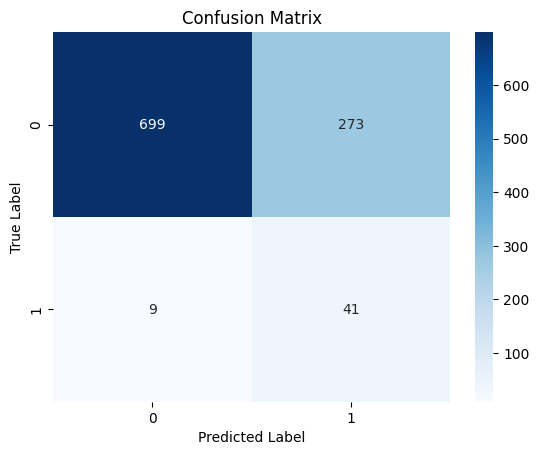

In [102]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

From the confusion matric above we can see that the model is able to correctly identify most of the non stroke cases (699 out of 972), however, there is a high number of false positives (273), which, as discussed before, might be acceptable to ensure a low number of missed stroke diagnoses.
Also the model has a low number of false negatives (9), meaning it misses very few stroke cases. This is reflected in the high recall score for the true class (stroke cases), which is what the model aimed to optimize.
The true positives of 41 represent the stroke cases that the model correctly identified.

### Feature importance

In [103]:
num_feature_names = numeric_features
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
bool_feature_names = boolean_features
feature_names = num_feature_names + list(cat_feature_names) + ['smoking_status'] + bool_feature_names


if len(feature_names) != len(model.coef_[0]):
    print("Error: The number of feature names and coefficients does not match.")
    print(f"Number of feature names: {len(feature_names)}, Number of coefficients: {len(model.coef_[0])}")
else:
    coefficients = pd.DataFrame(model.coef_[0], index=feature_names, columns=['Coefficient'])
    print(coefficients.sort_values(by='Coefficient', ascending=False))

                         Coefficient
age                         1.637122
hypertension                0.379353
avg_glucose_level           0.190691
work_type_Private           0.115840
ever_married_Yes            0.098627
smoking_status              0.082919
heart_disease               0.081503
work_type_Never_worked     -0.005552
bmi                        -0.008528
work_type_Govt_job         -0.014925
work_type_children         -0.039215
work_type_Self-employed    -0.056122
ever_married_No            -0.098601


Age is the most significant facor indicating that the chance of having a stroke increases with age. Hypertension is also a strong predictor and that consistent with medical information(high blood pressure is a risk factor for stroke). Average glucose level is  moderately important suggesting that higher glucose levels are relevant to stroke risk. Being employed in the private sector and an ordinal smoking status are somewhat important when diagnosing the stroke. Being ever married shows a small positive correlation with stroke. Heart disease is a positive but less influential factor compared to other factors.

In [104]:
y_pred_proba = optimized_pipeline_LR.predict_proba(X_test)[:, 1]
for threshold in np.arange(0.1, 0.9, 0.1):
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    print(f"Threshold: {threshold:.1f}, Recall: {recall_score(y_test, y_pred_threshold):.2f}, Precision: {precision_score(y_test, y_pred_threshold):.2f}")

Threshold: 0.1, Recall: 0.98, Precision: 0.07
Threshold: 0.2, Recall: 0.90, Precision: 0.08
Threshold: 0.3, Recall: 0.84, Precision: 0.09
Threshold: 0.4, Recall: 0.84, Precision: 0.11
Threshold: 0.5, Recall: 0.82, Precision: 0.13
Threshold: 0.6, Recall: 0.76, Precision: 0.17
Threshold: 0.7, Recall: 0.68, Precision: 0.21
Threshold: 0.8, Recall: 0.44, Precision: 0.27


As the threshold for predicting a stroke increases from 0.1 to 0.8 (default was used of 0.5 in the model) recall decreases while precision increases. Let;s look at the precision recall curve.

### If we maximize recall and precision balance (f1 score)

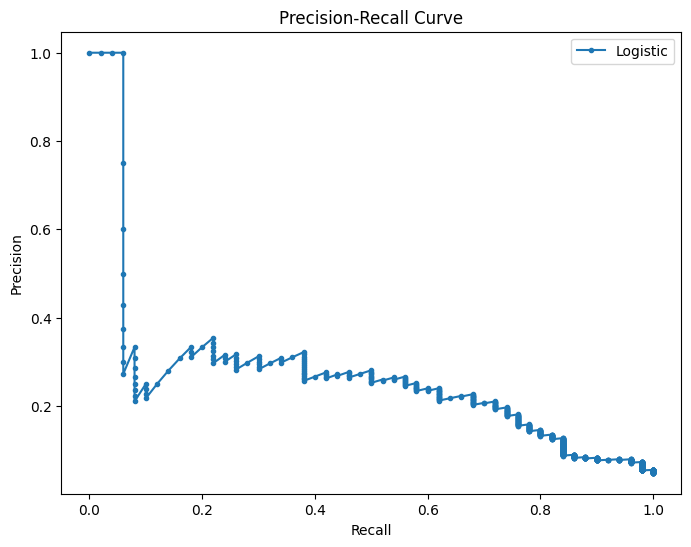

Best Threshold=0.779662, F1-Score=0.361
Optimized Precision: 0.26666666666666666
Optimized Recall: 0.56
Optimized F1 Score: 0.3612903225806452


In [105]:
X_test_preprocessed = preprocessor.transform(X_test)

y_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)  #max f1 score
best_threshold = thresholds[ix]
best_f1 = fscore[ix]

print('Best Threshold=%f, F1-Score=%.3f' % (best_threshold, best_f1))

y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)
print(f"Optimized Precision: {precision_score(y_test, y_pred_optimized)}")
print(f"Optimized Recall: {recall_score(y_test, y_pred_optimized)}")
print(f"Optimized F1 Score: {f1_score(y_test, y_pred_optimized)}")

With 56% recall we could increase precision to ~36%

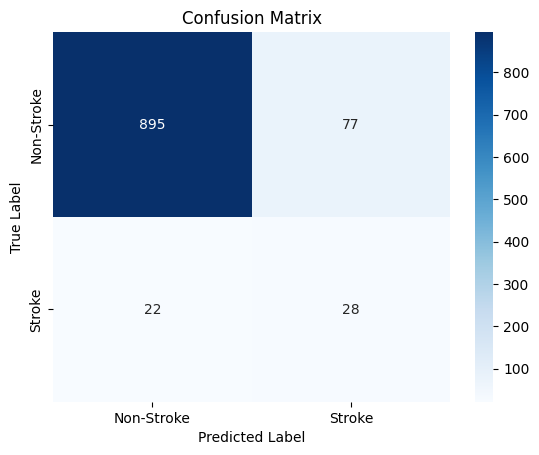

In [106]:
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_optimized)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Stroke', 'Stroke'],
            yticklabels=['Non-Stroke', 'Stroke'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

If we would optimize according to f1 score we would decrease the number of 41 true positive stroke classifications to 28, increase false negative to 22 from 9, however we would highly decrease false positive cases to 77. For now we will stay with higher recall score.

### ROC CURVE

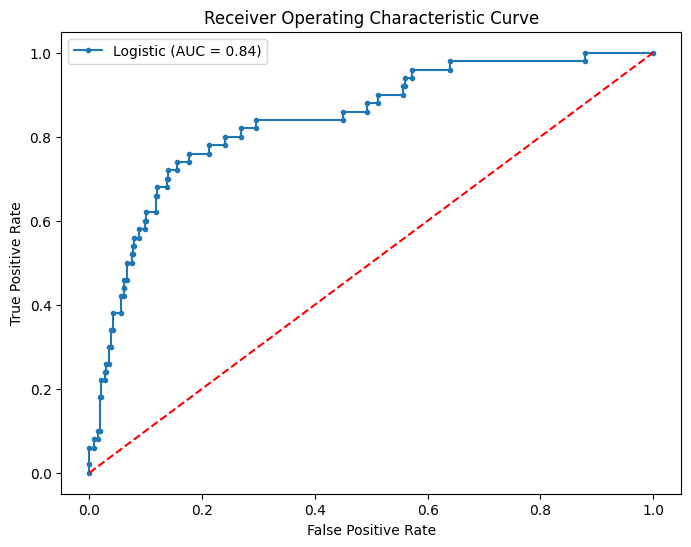

ROC AUC: 0.841


In [107]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f'Logistic (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

print(f"ROC AUC: {roc_auc:.3f}")

I think this ROC curve looks very good, of course it would be great to compore it to other model as well. The AUC is 0.84 and that indicates a good level of discrimination for the logistic regression model meaning it is good at distinguishing between the patients who have had a stroke and the negative category, those that did not have stroke.

The curve stays quite above the red dashed line, this line represents just a random guessing (like our baseline model). It rises quickly towards a high true positive rate (sensitivity), which says that the model correctly identifies a large proportion of actual positives while keeping the false positive rate relatively low.

### Conclusions

Logistic regression model as explored to predic stroke cases given only several features. We manage to increase recall to 80% however at the cost of precision.

age, hypertension, navg_glucose_level, work_type_Private seems to be most positive influencial factors in classification of stroke cases.

improvements to the model:
feature tranformation exploration
other model exploration like XGboost model

In [115]:
with open('trained_pipeline-0.1.0.pkl','wb') as f:
    pickle.dump(optimized_pipeline_LR, f)